##  HACKATHON MIA 2025 - Groupe 20

### MODEL CNN :: Détection des émotions faciales humaines

<u>Projet:</u> Ce projet se concentre sur la détection des émotions à partir d'images faciales à l'aide d'un réseau neuronal convolutif (CNN).

<u>Objectif:</u> Développer un modèle d'apprentissage profond robuste, capable de classer avec précision les émotions faciales.

#### Installation des bibliothèques nécessaires

In [1]:
"""
!pip install pandas 
!pip install seaborn 
!pip install mlflow

# # Suppression des versions conflictuelles d'OpenCV avant réinstallation

!pip uninstall opencv-python-headless opencv-python -y
!pip install opencv-python-headless
"""


"\n!pip install pandas \n!pip install seaborn \n!pip install mlflow\n\n# # Suppression des versions conflictuelles d'OpenCV avant réinstallation\n!pip uninstall opencv-python-headless opencv-python -y\n!pip install opencv-python-headless\n"

#### Importation des bibliothèques nécessaires

In [6]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from collections import Counter

#### Définition du chemin du dataset

In [4]:
dataset_path = "datas/kaggle_sources/"

#### Exploration des données (visualisations et analyses) 

##### Liste des classes présentes dans le dataset

/tmp/ipykernel_227305/901615674.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


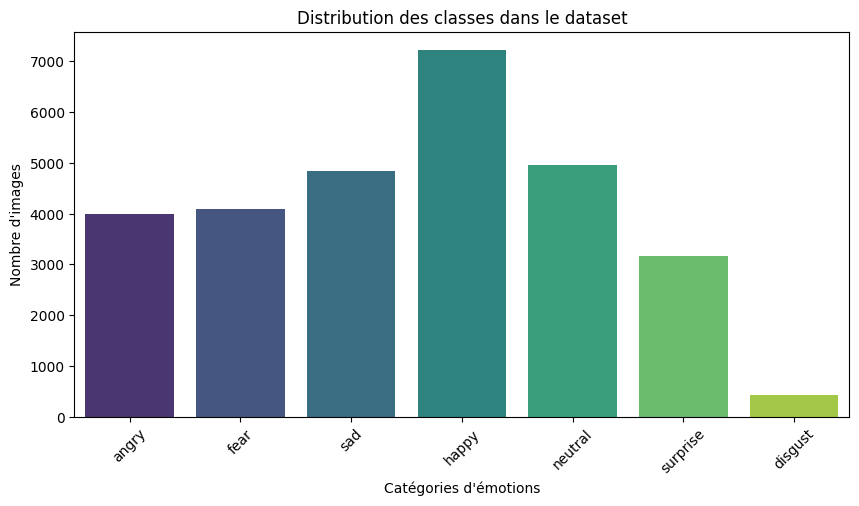

In [8]:
class_names = os.listdir(dataset_path + "train")

class_counts = {cls: len(os.listdir(os.path.join(dataset_path + "train", cls))) for cls in class_names}

# display
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xlabel("Catégories d'émotions")
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes dans le dataset")
plt.xticks(rotation=45)
plt.show()

##### Afficher des images d'une classe donnée

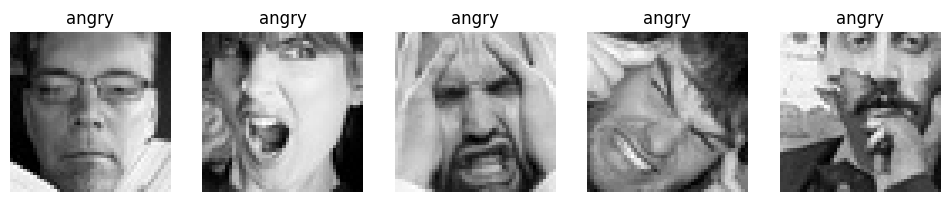

In [9]:
def plot_images_from_class(class_name, num_images=5):
    class_path = os.path.join(dataset_path + "train", class_name)
    image_files = os.listdir(class_path)[:num_images]
    
    plt.figure(figsize=(12, 6))
    for i, img_file in enumerate(image_files):
        img = plt.imread(os.path.join(class_path, img_file)) 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
    plt.show()


plot_images_from_class(class_names[0])


##### Vérification des tailles d’images

In [ ]:
img_sizes = []
for cls in class_names:
    class_path = os.path.join(dataset_path + "train", cls)
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_sizes.append(img.shape)

print("Différentes tailles d'images trouvées :", set(img_sizes))


Différentes tailles d'images trouvées : {(48, 48)}


#### Chargement et prétraitement des données


##### Données d'entraînement 

In [11]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "train",
    image_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    shuffle=True,
    label_mode="categorical",
    validation_split=0.2,
    subset="training", 
    seed=123
)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.


2025-03-13 02:08:41.564108: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


##### Données de validation

In [12]:
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "train", 
    image_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    shuffle=True,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation", 
    seed=123
)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


##### Données de test

In [13]:
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "test",
    image_size=(48,48),
    batch_size=32,
    color_mode="grayscale",
    shuffle=False,
    label_mode="categorical"
)

Found 7178 files belonging to 7 classes.


##### Vérification de la taille des jeux de données

In [14]:
print(f"Train dataset size: {len(ds_train)}")
print(f"Validation dataset size: {len(ds_val)}")
print(f"Test dataset size: {len(ds_test)}")

Train dataset size: 718
Validation dataset size: 180
Test dataset size: 225


#### Création et compilation du modèle CNN


In [ ]:
# modèle CNN
model = tf.keras.Sequential([
    # Convolution 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Convolution 2
    tf.keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Convolution 3
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Couche Flatten + Denses
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # Couche de sortie
    tf.keras.layers.Dense(7, activation='softmax')  
])

# Compil
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 23, 23, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,232,199 (16.14 MB)

 Trainable params: 4,229,255 (16.13 MB)

 Non-trainable params: 2,944 (11.50 KB)

#### Suivi avec MLflow


##### Configuration du suivi des expériences avec MLflow

In [38]:
import mlflow
from mlflow.models import infer_signature

mlflow_tracking = "sqlite:///emotion.db"
mlflow.set_tracking_uri(mlflow_tracking)
experiment_name = "emotion_detector"
mlflow.set_experiment(experiment_name)
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: sqlite:///emotion.db


##### Entraînement du modèle avec suivi MLflow

In [39]:
#  MLflowCallback
class MLflowCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            # Log
            mlflow.log_metric("accuracy", logs.get("accuracy", 0), step=epoch)
            mlflow.log_metric("val_accuracy", logs.get("val_accuracy", 0), step=epoch)
            mlflow.log_metric("loss", logs.get("loss", 0), step=epoch)
            mlflow.log_metric("val_loss", logs.get("val_loss", 0), step=epoch)

class LearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

# Run
with mlflow.start_run():
    mlflow.log_param("learning_rate_initial", 0.0001) 
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint, reduce_lr, MLflowCallback(), LearningRateCallback()]
    )

    example_input = np.random.rand(1, 48, 48, 1).astype(np.float32)
    signature = infer_signature(example_input, model.predict(example_input))

    mlflow.keras.log_model(model, "emotion_detector_model", signature=signature, input_example=None)


Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 156s 213ms/step - accuracy: 0.2145 - loss: 4.4208 - val_accuracy: 0.3398 - val_loss: 3.6460 - learning_rate: 1.0000e-04
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 154s 215ms/step - accuracy: 0.3127 - loss: 3.7244 - val_accuracy: 0.3897 - val_loss: 3.2326 - learning_rate: 1.0000e-04
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 157s 219ms/step - accuracy: 0.3719 - loss: 3.2443 - val_accuracy: 0.4473 - val_loss: 2.7594 - learning_rate: 1.0000e-04
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 154s 215ms/step - accuracy: 0.4101 - loss: 2.8419 - val_accuracy: 0.4370 - val_loss: 2.5339 - learning_rate: 1.0000e-04
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 151s 211ms/step - accuracy: 0.4426 - loss: 2.5058 - val_accuracy: 0.4834 - val_loss: 2.1985 - learning_rate: 1.0000e-04
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 152s 212ms/step - accuracy: 0.4640 - loss: 2.2292 - val_accuracy: 0.5027 - val_loss: 2.0010 - learning_rate: 1.0000e-04
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 